In [1]:
import pandas as pd
import numpy as np
import h5py

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as mpatches
# %matplotlib inline
plt.rcParams["animation.html"] = "html5"
import seaborn as sns
# from IPython.display import HTML

from skbio.stats import ordination
from sklearn.decomposition import PCA

from tqdm import tqdm

import sys
sys.path.insert(1, '../scripts')
from load_environmental_variables import *

/home/hratch/anaconda3/envs/CD8T_RA/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [164]:
# load files

# read in t0 cci timepoint
colnames = open(local_data_path + 'interim/velocyto_analyses/column_names.txt').read().splitlines() # cell barcodes in order of CCI distance matrices
# cell_ids = pd.read_csv(local_data_path + 'processed/5k_pbmc_celltypes_velocytoformatted.csv', index_col = 0) # map cell barcodes to cell type
# cell_id_map = dict(zip(cell_ids.SampleID, cell_ids.Cell_Type)) # 

cci_dt = h5py.File(local_data_path + 'interim/CCI_dt.h5', "r")
cci_t0 = pd.DataFrame(cci_dt[sorted(cci_dt.keys())[0]], columns = colnames, index = colnames)

# load metadata (including pseudotime) from velocyto analysis
metadata = pd.read_csv(local_data_path + 'interim/velocyto_analyses/velocyto_attributes.csv', index_col = 0)

# Static Time Point + Psuedotime

In [165]:
cci_t0 = 1- cci_t0
np.fill_diagonal(cci_t0.values, 0) # format for pcoa
cci_pcoa = ordination.pcoa(distance_matrix = cci_t0, number_of_dimensions = 3) # do pcoa
cci_pcoa.samples.index = colnames # format for emperor
cci_pcoa.samples.to_csv(local_data_path + 'interim/cci_nonprojected_pcoa.csv')
pcoa = pd.read_csv(local_data_path + 'interim/cci_nonprojected_pcoa.csv', index_col = 0)

/home/hratch/anaconda3/envs/immune_CCI/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:152: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -8.055978330409273 and the largest is 21.620873300032358.
  RuntimeWarning


In [166]:
metadata = metadata.loc[pcoa.index, :]
viz_df = pd.concat([metadata[['Cell_Type','velocity_pseudotime']], pcoa], axis = 1)
n_bins = 100
viz_df['time'] = pd.qcut(x = viz_df.velocity_pseudotime, q = n_bins, 
                              labels = list(range(n_bins)), duplicates = 'drop')

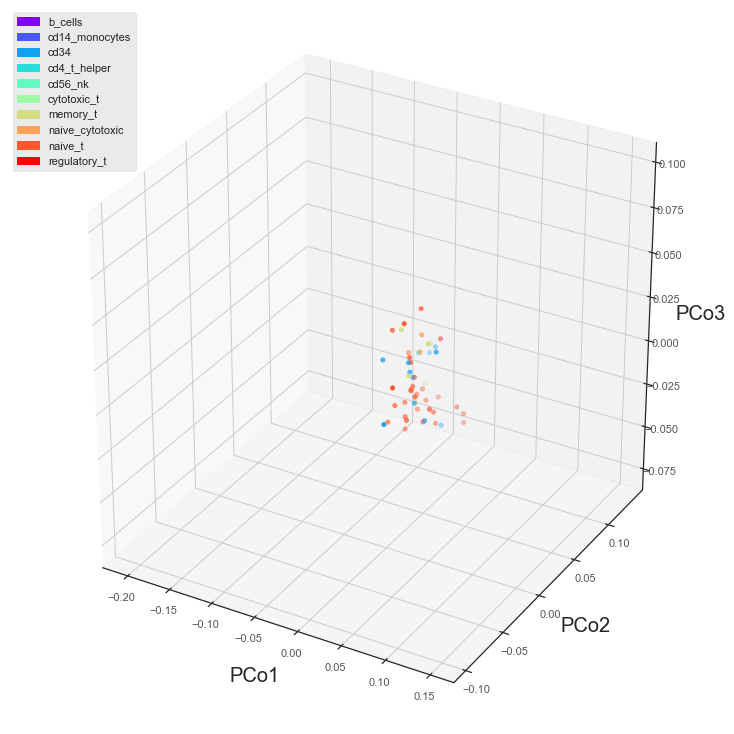

In [167]:
#https://stackoverflow.com/questions/47503534/how-to-dynamically-change-point-colors-in-scatter3d-animation-with-matplotlib
sns.set(style = 'white')
uct = sorted(viz_df.Cell_Type.unique())
cmap_ = dict(zip(uct, matplotlib.cm.rainbow(np.linspace(0, 1, len(uct))).tolist()))
colors = [viz_df[viz_df.time == t].Cell_Type.map(cmap_).values for t in sorted(viz_df.time.unique())]
handles_ = [mpatches.Patch(color=c_, label=ct) for ct, c_ in cmap_.items()]

def constant_axes(ax3d):
    ax3d.set(xlim = (min(viz_df.PC1), max(viz_df.PC1)), 
                    ylim = (min(viz_df.PC2), max(viz_df.PC2)),
                    zlim = (min(viz_df.PC3), max(viz_df.PC3)))
    ax3d.legend(handles=handles_, loc='upper left')#bbox_to_anchor=(1.07, 0.5))
    ax3d.set_xlabel('PCo1', fontsize = 20, labelpad = 15)
    ax3d.set_ylabel('PCo2', fontsize = 20, labelpad = 15)
    ax3d.set_zlabel('PCo3', fontsize = 20, labelpad = 15)

fig = plt.figure(figsize = (10,10))
ax3d = Axes3D(fig)
constant_axes(ax3d)
ttl = ax3d.text2D(0.05, 0.95, "", transform=ax3d.transAxes)


def update_plot(i):
    ttl.set_text('time = {}'.format(i))
    data=viz_df[viz_df['time']==i]
    ax3d.clear()
    constant_axes(ax3d)
    ax3d.scatter(data.PC1, data.PC2, data.PC3, c=colors[i])

def init():
    ax3d.scatter([],[],[])
    plt.style.use('ggplot')
    
    
ani = animation.FuncAnimation(fig, update_plot, init_func=init, frames=range(n_bins),
                              blit=False, interval=350)
ani.save(local_data_path + 'figures/nonprojected_CCI_movie.gif', writer="imagemagick")

# Projected Time Points

In [144]:
metadata = pd.read_csv(local_data_path + 'interim/velocyto_analyses/velocyto_attributes.csv', index_col = 0)

In [146]:
all_cci = np.empty(shape = (cci_t0.shape[0], 0))
for t in tqdm(sorted(cci_dt.keys())):
    all_cci = np.concatenate([all_cci, cci_dt[t]], axis = 1)

In [ ]:
timepoints = list(cci_dt.keys())

# run pca
pca_res = PCA(n_components = 3, svd_solver='auto').fit_transform(all_cci.T)

viz_df = pd.DataFrame(pca_res, columns = ['PC1', 'PC2', 'PC3'])
viz_df['time'] = [item for sublist in [[i]*cci_t0.shape[0] for i in timepoints] for item in sublist] 
viz_df['Cell_Type'] = pd.Series(colnames).map(dict(zip(metadata.index, metadata.Cell_Type))).tolist()*len(timepoints)
# since PT is abstract, just make it 0-100
viz_df.time = viz_df.time.map(dict(zip(sorted(timepoints), range(len(timepoints))))) 
viz_df.time = viz_df.time.astype(float)

In [ ]:
#https://stackoverflow.com/questions/47503534/how-to-dynamically-change-point-colors-in-scatter3d-animation-with-matplotlib
sns.set(style = 'white')
uct = sorted(viz_df.Cell_Type.unique())
cmap_ = dict(zip(uct, matplotlib.cm.rainbow(np.linspace(0, 1, len(uct))).tolist()))
colors = [viz_df[viz_df.time == t].Cell_Type.map(cmap_).values for t in sorted(viz_df.time.unique())]
handles_ = [mpatches.Patch(color=c_, label=ct) for ct, c_ in cmap_.items()]

def constant_axes(ax3d):
    ax3d.set(xlim = (min(viz_df.PC1), max(viz_df.PC1)), 
                    ylim = (min(viz_df.PC2), max(viz_df.PC2)),
                    zlim = (min(viz_df.PC3), max(viz_df.PC3)))
    ax3d.legend(handles=handles_, loc='upper left')#bbox_to_anchor=(1.07, 0.5))
    ax3d.set_xlabel('PC1', fontsize = 20, labelpad = 15)
    ax3d.set_ylabel('PC2', fontsize = 20, labelpad = 15)
    ax3d.set_zlabel('PC3', fontsize = 20, labelpad = 15)

fig = plt.figure(figsize = (10,10))
ax3d = Axes3D(fig)
constant_axes(ax3d)
ttl = ax3d.text2D(0.05, 0.95, "", transform=ax3d.transAxes)


def update_plot(i):
    ttl.set_text('time = {}'.format(i))
    data=viz_df[viz_df['time']==i]
    ax3d.clear()
    constant_axes(ax3d)
    ax3d.scatter(data.PC1, data.PC2, data.PC3, c=colors[i])

def init():
    ax3d.scatter([],[],[])
    plt.style.use('ggplot')
    
    
ani_2 = animation.FuncAnimation(fig, update_plot, init_func=init, frames=range(len(timepoints)),
                              blit=False, interval=350)
ani_2.save(local_data_path + 'figures/projected_CCI_movie.gif', writer="imagemagick")

# Projected Time Points, Filter HVI (Highly-Variable Interactions)

In [ ]:
cci_std = np.std(all_cci, axis = 1) # get CCI variance
# filter for 90th percentile by variance of CCI
top_cells_idx = [item for sublist in np.argwhere(cci_std  > np.percentile(cci_std, 90)).tolist() for item in sublist]  

# filter for it across all time points - NEED TO DOUBLE CHECK THIS IS CORRECT
top_cells_iter = []
for i in range(len(timepoints)):
    add_ = i*cci_t0.shape[0]
    top_cells_iter += (np.array(top_cells_idx) + add_).tolist()

all_cci_filtered = all_cci[:, top_cells_iter]

In [ ]:
# run pca
pca_res = PCA(n_components = 3, svd_solver='auto').fit_transform(all_cci_filtered.T)

In [ ]:
viz_df = pd.DataFrame(pca_res, columns = ['PC1', 'PC2', 'PC3'])
viz_df['time'] = [item for sublist in [[i]*len(top_cells_idx) for i in timepoints] for item in sublist] 
viz_df['Cell_Type'] = pd.Series(pd.Series(colnames)[top_cells_idx]).map(dict(zip(metadata.index, 
                                                       metadata.Cell_Type))).tolist()*len(timepoints)
viz_df.time = viz_df.time.map(dict(zip(sorted(timepoints), range(len(timepoints)))))
viz_df.time = viz_df.time.astype(float)

In [ ]:
#https://stackoverflow.com/questions/47503534/how-to-dynamically-change-point-colors-in-scatter3d-animation-with-matplotlib
sns.set(style = 'white')
uct = sorted(viz_df.Cell_Type.unique())
cmap_ = dict(zip(uct, matplotlib.cm.rainbow(np.linspace(0, 1, len(uct))).tolist()))
colors = [viz_df[viz_df.time == t].Cell_Type.map(cmap_).values for t in sorted(viz_df.time.unique())]
handles_ = [mpatches.Patch(color=c_, label=ct) for ct, c_ in cmap_.items()]

def constant_axes(ax3d):
    ax3d.set(xlim = (min(viz_df.PC1), max(viz_df.PC1)), 
                    ylim = (min(viz_df.PC2), max(viz_df.PC2)),
                    zlim = (min(viz_df.PC3), max(viz_df.PC3)))
    ax3d.legend(handles=handles_, loc='upper left')#bbox_to_anchor=(1.07, 0.5))
    ax3d.set_xlabel('PC1', fontsize = 20, labelpad = 15)
    ax3d.set_ylabel('PC2', fontsize = 20, labelpad = 15)
    ax3d.set_zlabel('PC3', fontsize = 20, labelpad = 15)

fig = plt.figure(figsize = (10,10))
ax3d = Axes3D(fig)
constant_axes(ax3d)
ttl = ax3d.text2D(0.05, 0.95, "", transform=ax3d.transAxes)


def update_plot(i):
    ttl.set_text('time = {}'.format(i))
    data=viz_df[viz_df['time']==i]
    ax3d.clear()
    constant_axes(ax3d)
    ax3d.scatter(data.PC1, data.PC2, data.PC3, c=colors[i])

def init():
    ax3d.scatter([],[],[])
    plt.style.use('ggplot')
    
    
ani_3 = animation.FuncAnimation(fig, update_plot, init_func=init, frames=range(len(timepoints)),
                              blit=False, interval=350)
ani_3.save(local_data_path + 'figures/projected_HVI_CCI_movie.gif', writer="imagemagick")